In [1]:
from __future__ import print_function
import os
import re
from PIL import Image
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/jiajiechen/Desktop/project2-CSE6240/code')
from image_parser import image_parser

## Read Data, the image_parser is implemented in image_parser.py

In [2]:
datapath="/Users/jiajiechen/Desktop/project2-CSE6240/Data"

In [3]:
animals=image_parser(folder="01-Animal",datapath=datapath,
                     verbose=False,min_rows=20,min_cols=20)

In [4]:
geo_form=image_parser(folder="03-Geological Formation",datapath=datapath,
                     verbose=False,min_rows=20,min_cols=20)

In [5]:
animals.read()

In [6]:
animals.images.shape

(1571, 400)

In [7]:
geo_form.read()

In [8]:
geo_form.images.shape

(1808, 400)

In [9]:
# normalize data, make all values within 0-255
X = (1.0*np.vstack((animals.images,geo_form.images)))/255

In [10]:
y = np.concatenate((np.zeros(animals.images.shape[0]), np.ones(geo_form.images.shape[0])), axis=0)

In [11]:
del(animals,geo_form)

## 4) Train two categories together by picking 80% of the data points. Encode the rest 20% and measure the encoding error.

In [41]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

# y is label, used for later on indexing images, because we will train them seperately later on.

(2703, 400) (676, 400)


#### Implement K-sparse-autoencoder

In [13]:
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

class KSparseAutoencoder(object):
    """K Sparse Auto-Encoder
       This structure is borrowed from
       http://deeplearning.net/tutorial/dA.html
    """

    def __init__(self,
                 numpy_rng,
                 input=None,
                 n_visible=400,
                 n_hidden=400,
                 K=20,
                 W=None,
                 bhid=None,
                 bvis=None):

        self.n_visible = n_visible
        self.n_hidden = n_hidden

        initial_W = np.asarray(
            numpy_rng.uniform(low=-4 * np.sqrt(6. / (n_hidden + n_visible)),
                              high=4 * np.sqrt(6. / (n_hidden + n_visible)),
                              size=(n_visible, n_hidden)),dtype=theano.config.floatX)
        W = theano.shared(value=initial_W, name='W', borrow=True)

        bvis = theano.shared(value=np.zeros(n_visible,dtype=theano.config.floatX),
                             borrow=True)
        bhid = theano.shared(value=np.zeros(n_hidden,dtype=theano.config.floatX),
                             name='b',
                             borrow=True)    
        self.K=K
        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        # tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
        self.x = input
        self.params = [self.W, self.b, self.b_prime]

    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.dot(input, self.W) + self.b
    
    def get_k_sparse(self,hidden):
        """ Keep the K largest element and make hidden layer sparse """
        index_theano=hidden.argsort()
        return T.set_subtensor(hidden[index_theano<self.K], 0)

    def get_reconstructed_input(self, hidden):
        return T.dot(hidden, self.W_prime) + self.b_prime

    def get_cost_updates(self, learning_rate):
        z = self.get_hidden_values(self.x)
        z_sparse = self.get_k_sparse(z)
        xhat = self.get_reconstructed_input(z_sparse)
        
        cost =T.mean(T.sqrt(T.sum(T.sqr(self.x-xhat),axis=0)))
        
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]
        W_out=self.W
        b_out=self.b
        b_prime_out=self.b_prime
        return (cost, updates, xhat, W_out, b_out, b_prime_out)

In [42]:
#set minibatch size
batch_size=20
n_train_batches = int(X_train.shape[0]) / batch_size

# allocate symbolic variables for the data
index = T.lscalar()
x = T.matrix('x')
x_input = theano.shared(X_train, name = 'x input')

rng = np.random.RandomState(19930319)

da = KSparseAutoencoder(
    numpy_rng=rng,
    input=x,
    n_visible=X_train.shape[1],
    n_hidden=400, #we do not decrease dimension, just enforce sparsity in hidden layer
    K=20
)

cost, updates, xhat, W_out, b_out, b_prime_out = da.get_cost_updates(learning_rate=0.5)

train_da = theano.function(
    [index],
    outputs=[cost,xhat,W_out,b_out,b_prime_out],
    updates=updates,
    givens={
        x: x_input[index*batch_size:(index + 1)*batch_size]
    }
)

# go through training epochs
average_train_cost_together=[]

for epoch in range(20):
    J = []
    # go through trainng set
    for batch_index in range(n_train_batches):
        output=train_da(batch_index)
        J.append(output[0])
    print('Training epoch %d, cost=' % epoch, np.mean(J))
    average_train_cost_together.append(np.mean(J))

W_final,b_final,b_prime_final = output[2],output[3],output[4]

Training epoch 0, cost= 28.1262518036
Training epoch 1, cost= 13.1351978374
Training epoch 2, cost= 5.98117127693
Training epoch 3, cost= 3.21815792865
Training epoch 4, cost= 1.94286248231
Training epoch 5, cost= 1.2774050486
Training epoch 6, cost= 0.958220846345
Training epoch 7, cost= 0.82789425467
Training epoch 8, cost= 0.769078576697
Training epoch 9, cost= 0.739862307803
Training epoch 10, cost= 0.73128464895
Training epoch 11, cost= 0.723980268705
Training epoch 12, cost= 0.718411651825
Training epoch 13, cost= 0.712330298516
Training epoch 14, cost= 0.718491827736
Training epoch 15, cost= 0.713260445203
Training epoch 16, cost= 0.7108029946
Training epoch 17, cost= 0.707966154481
Training epoch 18, cost= 0.713043754484
Training epoch 19, cost= 0.710074356653


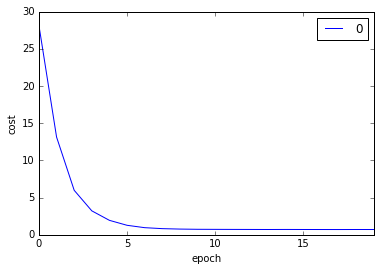

In [43]:
# plot the learning curve

%matplotlib inline
import matplotlib.pyplot as plt
pd.DataFrame(np.array(average_train_cost_together)).plot(label="train together")
plt.xlabel("epoch")
plt.ylabel("cost")

In [44]:
# test encoding error

print(W_final.shape,b_final.shape,b_prime_final.shape,X_test.shape)

xhat = (X_test.dot(W_final)+b_final).dot(W_final.T)+b_prime_final

print("test encoding error =",np.linalg.norm((xhat - X_test),'fro')**2)

(400, 400) (400,) (400,) (676, 400)
test encoding error = 6607.68134061


Note: We use squared (reconstruction) errors as encoding error

## 5) Train two categories individually by picking 80% of the data points. Encode the rest 20% and measure the encoding error.

In [19]:
#animal
animal = X[y==0]
geo_form = X[y==1]

In [20]:
del(X_train,X_test,y_train,y_test)

In [21]:
animal_train, animal_test = cross_validation.train_test_split(animal, test_size=0.2, random_state=0)
print(animal_train.shape, animal_test.shape)
geo_form_train, geo_form_test = cross_validation.train_test_split(geo_form, test_size=0.2, random_state=0)
print(geo_form_train.shape, geo_form_test.shape)

(1256, 400) (315, 400)
(1446, 400) (362, 400)


In [22]:
###Animal

#set minibatch size
batch_size=20
n_train_batches = int(animal_train.shape[0]) / batch_size

# allocate symbolic variables for the data
index = T.lscalar()
x = T.matrix('x')
x_input = theano.shared(animal_train, name = 'x input')

rng = np.random.RandomState(19930319)

da = KSparseAutoencoder(
    numpy_rng=rng,
    input=x,
    n_visible=animal_train.shape[1],
    n_hidden=400,
    K=20
)

cost, updates, xhat, W_out, b_out, b_prime_out = da.get_cost_updates(learning_rate=0.5)

train_da = theano.function(
    [index],
    outputs=[cost,xhat,W_out,b_out,b_prime_out],
    updates=updates,
    givens={
        x: x_input[index*batch_size:(index + 1)*batch_size]
    }
)

# go through training epochs
average_train_cost_animal=[]

for epoch in range(20):
    c = []
    # go through trainng set
    for batch_index in range(n_train_batches):
        output=train_da(batch_index)
        c.append(output[0])
    print('Training epoch %d, cost=' % epoch, np.mean(c))
    average_train_cost_animal.append(np.mean(c))

W_final,b_final,b_prime_final = output[2],output[3],output[4]

Training epoch 0, cost= 29.2591870366
Training epoch 1, cost= 20.5283565744
Training epoch 2, cost= 14.7170239462
Training epoch 3, cost= 10.2295081674
Training epoch 4, cost= 7.1868345704
Training epoch 5, cost= 5.10828371965
Training epoch 6, cost= 3.72289571817
Training epoch 7, cost= 2.90902216931
Training epoch 8, cost= 2.25826079935
Training epoch 9, cost= 1.81185917306
Training epoch 10, cost= 1.48853124385
Training epoch 11, cost= 1.23410433997
Training epoch 12, cost= 1.06717854321
Training epoch 13, cost= 0.953654648458
Training epoch 14, cost= 0.874658309642
Training epoch 15, cost= 0.81538521777
Training epoch 16, cost= 0.776195291619
Training epoch 17, cost= 0.749542898991
Training epoch 18, cost= 0.727543345622
Training epoch 19, cost= 0.716478185358


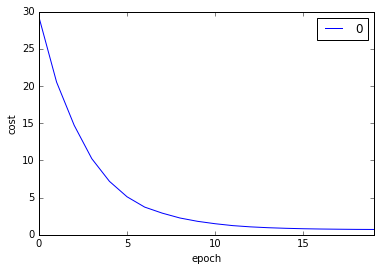

In [23]:
pd.DataFrame(np.array(average_train_cost_animal)).plot(label="train sep-animal")
plt.xlabel("epoch")
plt.ylabel("cost")

In [ ]:
animal_hat = (animal_test.dot(W_final)+b_final).dot(W_final.T)+b_prime_final - animal_test

In [38]:
print("animal test encoding error =",np.linalg.norm(animal_hat,'fro')**2)

animal test encoding error = 3001.32726622


In [26]:
###geo_form

#set minibatch size
batch_size=20
n_train_batches = int(geo_form_train.shape[0]) / batch_size

# allocate symbolic variables for the data
index = T.lscalar()
x = T.matrix('x')
x_input = theano.shared(geo_form_train, name = 'x input')

rng = np.random.RandomState(19930319)

da = KSparseAutoencoder(
    numpy_rng=rng,
    input=x,
    n_visible=geo_form_train.shape[1],
    n_hidden=400,
    K=20
)

cost, updates, xhat, W_out, b_out, b_prime_out = da.get_cost_updates(learning_rate=0.5)

train_da = theano.function(
    [index],
    outputs=[cost,xhat,W_out,b_out,b_prime_out],
    updates=updates,
    givens={
        x: x_input[index*batch_size:(index + 1)*batch_size]
    }
)

# go through training epochs
average_train_cost_geo=[]

for epoch in range(20):
    c = []
    # go through trainng set
    for batch_index in range(n_train_batches):
        output=train_da(batch_index)
        c.append(output[0])
    print('Training epoch %d, cost=' % epoch, np.mean(c))
    average_train_cost_geo.append(np.mean(c))

W_final,b_final,b_prime_final = output[2],output[3],output[4]

Training epoch 0, cost= 38.3197025431
Training epoch 1, cost= 26.9824636038
Training epoch 2, cost= 18.9207679145
Training epoch 3, cost= 12.8353822687
Training epoch 4, cost= 8.34898894047
Training epoch 5, cost= 5.58823057827
Training epoch 6, cost= 4.17471978079
Training epoch 7, cost= 3.23722162075
Training epoch 8, cost= 2.52410218005
Training epoch 9, cost= 1.95312191567
Training epoch 10, cost= 1.5563291209
Training epoch 11, cost= 1.25860009377
Training epoch 12, cost= 1.07261690989
Training epoch 13, cost= 0.93935667189
Training epoch 14, cost= 0.8575038465
Training epoch 15, cost= 0.813206419556
Training epoch 16, cost= 0.77674588448
Training epoch 17, cost= 0.768639558299
Training epoch 18, cost= 0.751062180924
Training epoch 19, cost= 0.742083308113


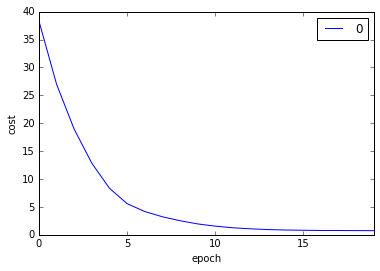

In [28]:
pd.DataFrame(np.array(average_train_cost_geo)).plot(label="train sep-geo")
plt.xlabel("epoch")
plt.ylabel("cost")

In [36]:
geo_hat = ((geo_form_test.dot(W_final)+b_final).dot(W_final.T)+b_prime_final - geo_form_test)
print("geo_form test encoding error =",np.linalg.norm(geo_hat,'fro')**2)

geo_form test encoding error = 3348.78222032


### Compare:

We can see that if train together, the test encoding error is 6607.68134061,
however, if train seperately, the test encoding errors are respectively 3001.32726622 and 3348.78222032

So, if train together, the average test encoding error is 9.774676539363906
if train seperately, the average test encoding error is 9.379777675834564

They are very close. So I would say sparse autoencoder manages to avoid confusion between them

# 6) Compare the sparse dictionaries from the 2 methods and state which one manages to avoid confusion between them